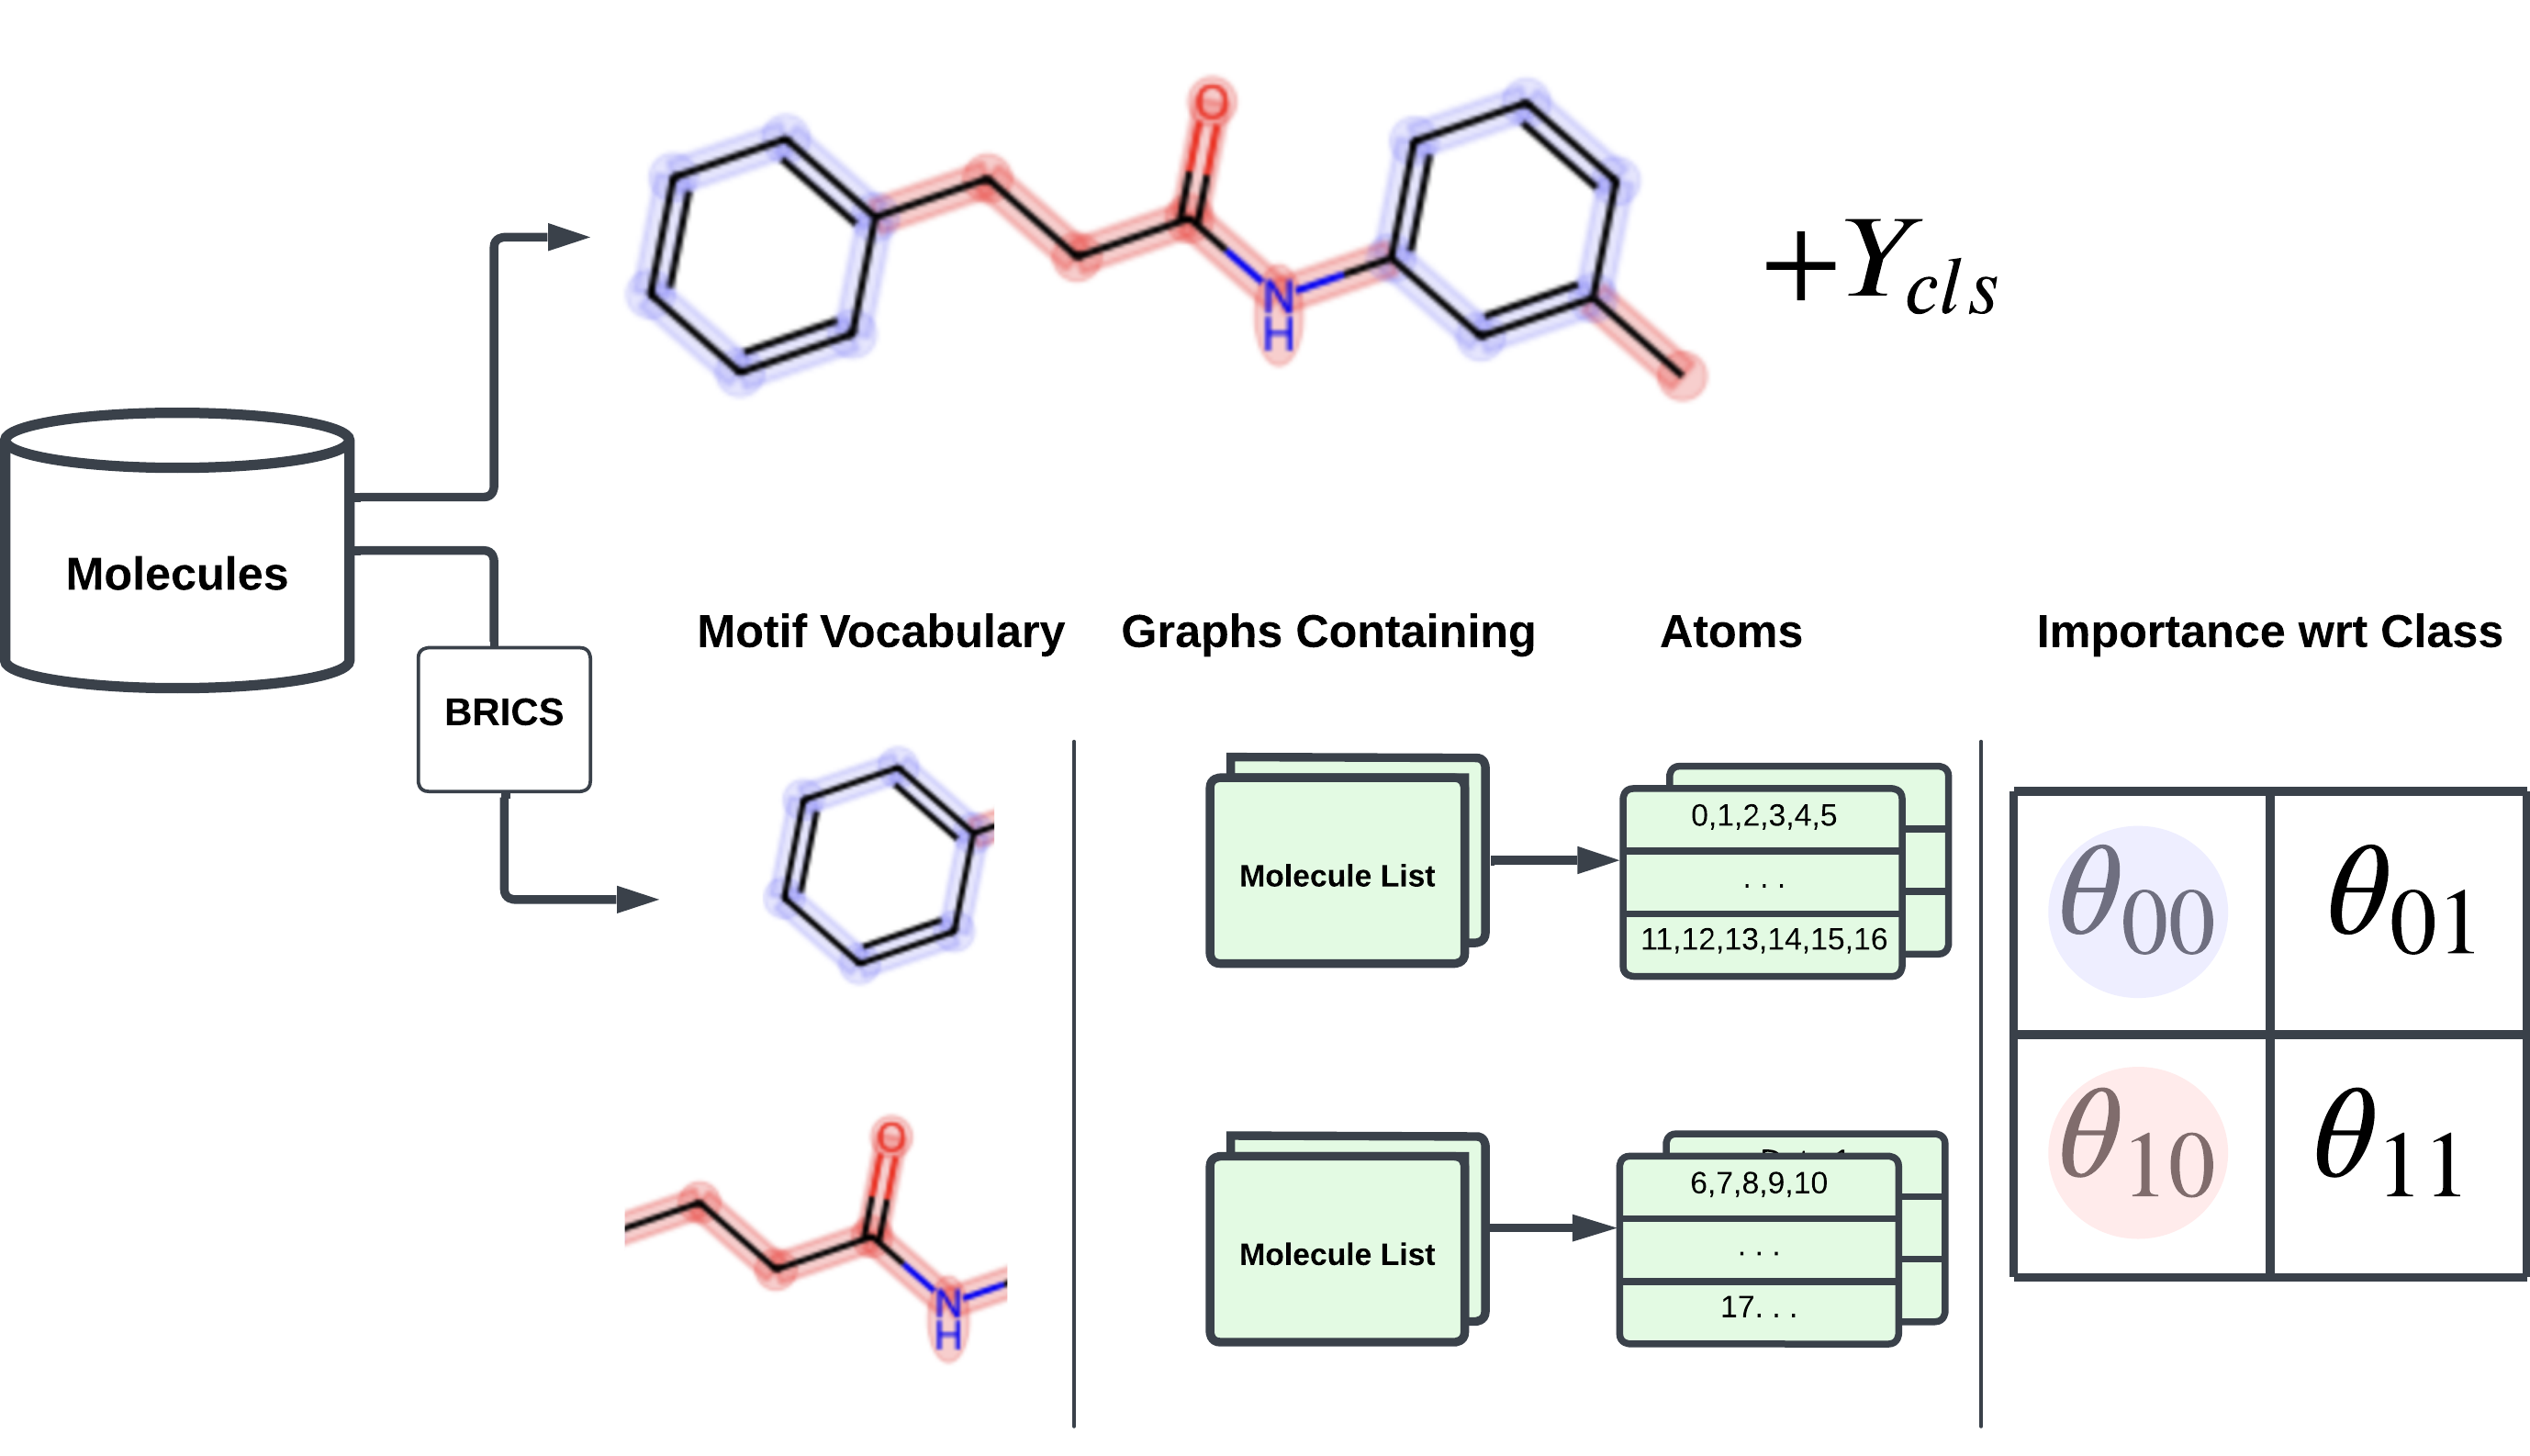

In [1]:
from IPython.display import Image
Image(filename='MotifVocab.png') 

In [2]:
#dataset_name = 'Lipophilicity' # Choose from 'Mutagenicity', 'hERG', 'BBBP', "esol', 'freesolv', 'Lipophilicity'
date_tag = '1225'

In [14]:
least_count_dict = {'Mutagenicity':{'RBRICS':[3,4], 'MGSSL':[3,4]}, 
                       'hERG':{'RBRICS':[10],'MGSSL':[15]}, 
                       'BBBP':{'RBRICS':[6],'MGSSL':[15],'ENERGY':[20]},
                       'Lipophilicity':{'RBRICS':[10],'MGSSL':[15]},
                       'esol':{'RBRICS':[5],'MGSSL':[5],'ENERGY':[5]}, 
                       'tox21':{'RBRICS':[5],'MGSSL':[3]},
                       'freesolv': {'ENERGY':[5]}}

In [15]:
# '''
# Code for spliting data
# '''
# import pandas as pd
# import numpy as np

# for random_state in [0,1,2,3,4]:
#     for dataset_name in ['tox21']:#['Mutagenicity', 'hERG', 'BBBP', 'esol', 'freesolv', 'Lipophilicity']:

#         # Load the Tox21 dataset CSV
#         df = pd.read_csv(f"datasets/_{dataset_name}.csv")

#         # Optional: Rename the target column to dataset name
#         # df.rename(columns={'exp': dataset_name}, inplace=True)

#         # Shuffle the dataset
#         df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

#         # Calculate split indices
#         train_size = int(0.8 * len(df))
#         valid_size = int(0.1 * len(df))

#         # Assign groups based on calculated indices
#         df['group'] = ['training'] * train_size + ['valid'] * valid_size + ['test'] * (len(df) - train_size - valid_size)

#         # Shuffle again to randomize rows within groups if needed
#         df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

#         df.to_csv(f"datasets/FOLDS/{dataset_name}_{random_state}.csv")
#         # Check the result
#         print(df['group'].value_counts())


group
training    6264
test         784
valid        783
Name: count, dtype: int64
group
training    6264
test         784
valid        783
Name: count, dtype: int64
group
training    6264
test         784
valid        783
Name: count, dtype: int64
group
training    6264
test         784
valid        783
Name: count, dtype: int64
group
training    6264
test         784
valid        783
Name: count, dtype: int64


# Loading Dataset

In [16]:
import csv
from collections import Counter, defaultdict
from Utils_vocab import *

In [17]:
import torch
import pandas as pd
from DataLoader import MolDataset
from collections import Counter
# Check if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
dataset_column_dict = {'Mutagenicity':['Mutagenicity'], 
                       'hERG':['hERG'], 
                       'BBBP':['BBBP'],
                       'Lipophilicity':['Lipophilicity'],
                       'tox21': ['NR-AR', 'NR-AR-LBD','NR-AhR','NR-Aromatase','NR-ER','NR-ER-LBD', 
                                 'NR-PPAR-gamma', 'SR-ARE','SR-ATAD5', 'SR-HSE','SR-MMP','SR-p53'],
                       'tox21_multiclass': 'tox21',
                       'esol':['measured log solubility in mols per litre'], 
                       'freesolv': ['expt']}

In [19]:
from DataLoader import MolDataset
import pickle
from Utils_Train import get_masked_graphs_from_list_for_each_motif

def write_to_file(data,dataset_name, fold, date_tag,least_count,artifact_name):
    with open(f'../DICTIONARY/FOLDS/{dataset_name}_{algorithm}_fold_{fold}_leastcount_{least_count}_{date_tag}_{artifact_name}.pickle', 'wb') as file:
        # Serialize and save the object to the file
        pickle.dump(data, file)

dataset_names = ['tox21']
for dataset_name in dataset_names:
    for fold in [0, 1, 2, 3, 4]:
        training_data = MolDataset(root=".", split='training',csv_file=f"datasets/FOLDS/{dataset_name}_{fold}.csv", label_col = dataset_column_dict[dataset_name])
        validation_data = MolDataset(root=".", split='valid',csv_file=f"datasets/FOLDS/{dataset_name}_{fold}.csv", label_col = dataset_column_dict[dataset_name])
        test_data = MolDataset(root=".", split='test',csv_file=f"datasets/FOLDS/{dataset_name}_{fold}.csv", label_col = dataset_column_dict[dataset_name])
        for algorithm in ["MGSSL","RBRICS"]: #"BRICS""Energy_100",
            try:
                least_counts = least_count_dict[dataset_name][algorithm]
            except:
                continue
            for least_count in least_counts:
                data_lookup, test_data_lookup, lookup_object = get_lookup_tables(training_data, validation_data, test_data, algorithm = algorithm)

                value_counts = Counter(
                    motif for graph_data in data_lookup.values() for motif in graph_data.values()
                )
                value_counts_test = Counter(
                    motif for graph_data in test_data_lookup.values() for motif in graph_data.values()
                )

                for motif, length in lookup_object.motifs_length.items():
                    value_counts[motif] /= length
                for motif, length in lookup_object.test_motifs_length.items():
                    value_counts_test[motif] /= length


                # Identify motifs to remove
                motifs_to_remove = {motif for motif, count in value_counts.items() if count <= least_count}
                lookup_object.remove_motifs(list(motifs_to_remove))

                # Reindex motifs and compute node coverage
                motif_list = list(lookup_object.get_all_unique_motif())

                train_val_coverage, graph_to_motifs = reindex_data(data_lookup, motif_list, value_counts, least_count)
                test_coverage, test_graph_to_motifs = reindex_data(test_data_lookup, motif_list, value_counts_test, least_count,is_test=True)

                test_mask_data = get_masked_graphs_from_list_for_each_motif(test_data, test_data_lookup, lookup_object.get_motif_lengths())
                train_mask_data = get_masked_graphs_from_list_for_each_motif(training_data, data_lookup, lookup_object.get_motif_lengths())
                val_mask_data = get_masked_graphs_from_list_for_each_motif(validation_data, data_lookup, lookup_object.get_motif_lengths())

                write_to_file(data_lookup,dataset_name, fold, date_tag,least_count,'graph_lookup')
                write_to_file(list(lookup_object.get_all_unique_motif()),dataset_name, fold, date_tag,least_count,'motif_list')
                write_to_file(lookup_object.get_motif_lengths(),dataset_name, fold, date_tag,least_count,'motif_length')
                write_to_file(value_counts,dataset_name, fold, date_tag,least_count,'motif_counts')
                write_to_file(lookup_object.motifs_class,dataset_name, fold, date_tag,least_count,'motif_class')
                write_to_file(graph_to_motifs,dataset_name, fold, date_tag,least_count,'graph_motifidx')
                write_to_file(test_graph_to_motifs,dataset_name, fold, date_tag,least_count,'test_graph_motifidx')
                write_to_file(test_data_lookup,dataset_name, fold, date_tag,least_count,'test_graph_lookup')
                write_to_file(lookup_object.get_test_motif_lengths(),dataset_name, fold, date_tag,least_count,'test_graph_motif_length')
                write_to_file(test_mask_data,dataset_name, fold, date_tag,least_count,'test_dataset_masked')
                write_to_file(train_mask_data,dataset_name, fold, date_tag,least_count,'train_dataset_masked')
                write_to_file(val_mask_data,dataset_name, fold, date_tag,least_count,'validation_dataset_masked')
    
    

[17:31:14] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:34] WARNING: not removing hydrogen atom without neighbors
[17:31:56] WARNING: not removing hydrogen atom without neighbors
[17:32:03] WARNING: not removing hydrogen atom without neighbors
[17:32:17] WARNING: not removing hydrogen atom without neighbors
[17:32:35] WARNING: not removing hydrogen atom without neighbors
[17:32:35] WARNING: not removing hydrogen atom without neighbors
[17:32:53] WARNING: not removing hydrogen atom without neighbors
[17:33:01] WARNING: not removing hydrogen atom without neighbors
[17:33:23] WARNING: not removing hydrogen atom without neighbors
[17:33:55] WARNING: not removing hydrogen atom without neighbors
[17:33:55] WARNING: not removing hydrogen atom without neighbors
[17:33:55] WARNING: not r

In [20]:
input()

KeyboardInterrupt: Interrupted by user

In [ ]:
{
     0: ('C', 4), 
     1: ('N', 5), 
     2: ('C', 4), 
     3: ('C', 4), 
     4: ('C', 4), 
     5: ('O', 7),
     6: ('C', 4), 
     7: ('O', 7), 
    
    8: ('c1ccccc1', 3), 
 9: ('c1ccccc1', 3), 
 10: ('c1ccccc1', 3), 
 11: ('c1ccccc1', 3), 
    12: ('N', 5), 
    13: ('c1cncnc1', 8), 
 14: ('c1cncnc1', 8), 
 15: ('c1cncnc1', 8), 
     16: ('N', 5), 
    17: ('c1ccccc1', 3), 
 18: ('c1ccccc1', 3), 
 19: ('c1ccccc1', 3), 
 20: ('Cl', 6),     
21: ('c1ccccc1', 3), 
 22: ('c1ccccc1', 3), 
 23: ('c1ccccc1', 3), 
  24: ('Cl', 6), 
 
 25: ('c1cncnc1', 8), 
 26: ('c1cncnc1', 8), 
 27: ('c1cncnc1', 8), 
28: ('c1ccccc1', 3), 
 29: ('c1ccccc1', 3), 
 

In [ ]:
from DataLoader import MolDataset
training_data = MolDataset(root=".", split='training',csv_file=f"datasets/{dataset_name}.csv", label_col = dataset_column_dict[dataset_name])
validation_data = MolDataset(root=".", split='valid',csv_file=f"datasets/{dataset_name}.csv", label_col = dataset_column_dict[dataset_name])
test_data = MolDataset(root=".", split='test',csv_file=f"datasets/{dataset_name}.csv", label_col = dataset_column_dict[dataset_name])

In [ ]:
training_data.num_classes, len(training_data), training_data.num_node_features, training_data.num_edge_features

In [ ]:
validation_data.num_classes, len(validation_data), validation_data.num_node_features, validation_data.num_edge_features

In [ ]:
test_data.num_classes, len(test_data), test_data.num_node_features, test_data.num_edge_features

In [ ]:
training_data = remove_bad_mols(training_data)
validation_data = remove_bad_mols(validation_data)
test_data = remove_bad_mols(test_data)

In [ ]:
training_data.num_classes, len(training_data), training_data.num_node_features, training_data.num_edge_features

In [ ]:
validation_data.num_classes, len(validation_data), validation_data.num_node_features, validation_data.num_edge_features

In [ ]:
test_data.num_classes, len(test_data), test_data.num_node_features, test_data.num_edge_features

# Create Motif Vocabulary

In [ ]:
lookup = MotifDictionary()

In [ ]:
# Process training and validation datasets
process_dataset(training_data + validation_data, lookup)

# Process test dataset
process_dataset(test_data, lookup, is_test=True)

In [ ]:
len(lookup.get_all_unique_motif())

In [ ]:
data_lookup = dict(lookup.data)
test_data_lookup = dict(lookup.test_data)

In [ ]:
value_counts = Counter(motif for graph_data in data_lookup.values() for motif in graph_data.values())
value_counts_test = Counter(motif for graph_data in test_data_lookup.values() for motif in graph_data.values())

In [ ]:
for motif, length in lookup.motifs_length.items():
    value_counts[motif] /= length
for motif, length in lookup.test_motifs_length.items():
    value_counts_test[motif] /= length

## Unit Testing. Check if number of motifs in each graph match

In [ ]:
from collections import Counter
# Count all motifs in each graph / divided by size of motif
total_motifs = 0
total_motifs_test = 0
for smiles, node_map in data_lookup.items():
    
    for node_idx, motif in node_map.items():
        
        length_of_motif = lookup.motifs_length[motif] 
        total_motifs += 1/length_of_motif


In [ ]:
verify_motif_count = 0
for motifs, length in lookup.motifs_length.items():
    verify_motif_count += value_counts[motifs]
    value_counts[motifs] = value_counts[motifs]/length
for motifs, length in lookup.test_motifs_length.items():
    value_counts_test[motifs] = value_counts_test[motifs]

In [ ]:
assert(round(total_motifs) == round(verify_motif_count))

In [ ]:
round(total_motifs), round(verify_motif_count)

In [ ]:
len([k for k,v in value_counts.items() if v < least_count])

In [ ]:
len([k for k,v in value_counts_test.items() if v < least_count])

# Filtering motifs that are rare

In [ ]:
# Identify motifs to remove
motifs_to_remove = {motif for motif, count in value_counts.items() if count <= least_count}
lookup.remove_motifs(list(motifs_to_remove))

In [ ]:
# Reindex motifs and compute node coverage
motif_list = list(lookup.get_all_unique_motif())

In [ ]:
train_val_coverage, graph_to_motifs = reindex_data(data_lookup, motif_list, value_counts, least_count)
train_val_coverage

In [ ]:
test_coverage, test_graph_to_motifs = reindex_data(test_data_lookup, motif_list, value_counts_test, least_count,is_test=True)
test_coverage

# Create Masked Dataset

In [ ]:
from Utils_Train import get_masked_graphs_from_list_for_each_motif
test_mask_data = get_masked_graphs_from_list_for_each_motif(test_data, test_data_lookup, lookup.get_motif_lengths())

In [ ]:
train_mask_data = get_masked_graphs_from_list_for_each_motif(training_data, data_lookup, lookup.get_motif_lengths())
val_mask_data = get_masked_graphs_from_list_for_each_motif(validation_data, data_lookup, lookup.get_motif_lengths())

# Saved lookup table

In [ ]:
import pickle
data_lookup = dict(lookup.data)
# Open a file in write mode
with open(f'dictionary/{dataset_name}_graph_lookup_{date_tag}.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(data_lookup, file)

with open(f'dictionary/{dataset_name}_motif_list_{date_tag}.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(list(lookup.get_all_unique_motif()), file)
    
with open(f'dictionary/{dataset_name}_motif_length_{date_tag}.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(lookup.get_motif_lengths(), file)
    
with open(f'dictionary/{dataset_name}_motif_counts_{date_tag}.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(value_counts, file)


In [ ]:
with open(f'dictionary/{dataset_name}_motif_class_{date_tag}.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(lookup.motifs_class, file)
    
with open(f'dictionary/{dataset_name}_graph_motifidx_{date_tag}.pickle', 'wb') as file:
    pickle.dump(graph_to_motifs, file)
    
with open(f'dictionary/{dataset_name}_test_graph_motifidx_{date_tag}.pickle', 'wb') as file:
    pickle.dump(test_graph_to_motifs, file)

In [ ]:
with open(f'dictionary/{dataset_name}_test_graph_lookup_{date_tag}.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(test_data_lookup, file)
    
with open(f'dictionary/{dataset_name}_test_graph_motif_length_{date_tag}.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(lookup.get_test_motif_lengths(), file)

In [ ]:
with open(f'dictionary/{dataset_name}_test_dataset_masked_{date_tag}.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(test_mask_data, file)
    
with open(f'dictionary/{dataset_name}_train_dataset_masked_{date_tag}.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(train_mask_data, file)
    
with open(f'dictionary/{dataset_name}_validation_dataset_masked_{date_tag}.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(val_mask_data, file)

In [ ]:
test_mask_data

In [ ]:
input()

# Visualization of motif occurences in dataset

In [ ]:
def count_binary_values(input_dict):
    output_dict = {}
    for key, graph_label in input_dict.items():
        values = list(graph_label.values())
        count_0 = values.count(0)
        count_1 = values.count(1)
        output_dict[key] = (count_0, count_1)
    return output_dict

value_counts = count_binary_values(lookup.motifs_class)

In [ ]:
'''
Plots all motif frequencies
'''
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# # Example data
# data = lookup.motifs_length
# counter = value_counts

# # Create a DataFrame from the data
# df = []
# classes = [0, 1]
# for key, length in data.items():
#     counts = counter[key]
#     for cls in classes:
#         df.append((key, length, cls, counts[cls]))
# df = pd.DataFrame(df, columns=['Key', 'Length', 'Class', 'Count'])

# # Sort DataFrame by Length in descending order
# df = df.sort_values(by='Length', ascending=False)

# # Create a mapping of motifs to unique integer values
# motif_mapping = {motif: i for i, motif in enumerate(df['Key'].unique())}

# # Create a new column for mapped motif numbers using .map
# df.loc[:, 'Key_Num'] = df['Key'].map(motif_mapping)

# # Split the data into two separate DataFrames for each class
# df_class_0 = df[df['Class'] == 0].copy()
# df_class_1 = df[df['Class'] == 1].copy()

# # Calculate the absolute difference in counts between Class 0 and Class 1 for each motif
# df_counts = df.pivot(index='Key', columns='Class', values='Count').fillna(0)
# df_counts['Difference'] = abs(df_counts[0] - df_counts[1])

# # Set a threshold for significant difference
# significant_threshold = 100  # Example threshold, adjust as needed
# significant_motifs = df_counts[df_counts['Difference'] > significant_threshold].index

# # Separate significant and non-significant motifs
# df_significant = df[df['Key'].isin(significant_motifs)].copy()
# df_non_significant = df[~df['Key'].isin(significant_motifs)].copy()

# # Plot significant motifs
# fig, ax = plt.subplots(figsize=(16, 10))

# for cls in classes:
#     subset = df_significant[df_significant['Class'] == cls]
#     ax.bar(subset['Key_Num'] + cls * 0.4, subset['Count'], width=0.4, label=f'Class {cls}', alpha=0.7)

# ax.set_title('Counts of Significant Motifs')
# ax.set_xlabel('Motifs')
# ax.set_ylabel('Count')
# ax.set_xticks([motif_mapping[motif] + 0.2 for motif in significant_motifs])
# ax.set_xticklabels(significant_motifs, rotation=45)
# ax.legend()
# plt.tight_layout()
# plt.show()

# # Plot non-significant motifs in groups of 100
# non_sig_motifs = df_non_significant['Key'].unique()
# num_groups = int(np.ceil(len(non_sig_motifs) / 100))

# for i in range(num_groups):
#     fig, ax = plt.subplots(figsize=(16, 10))
    
#     start = i * 100
#     end = (i + 1) * 100
#     current_motifs = non_sig_motifs[start:end]
#     df_current = df_non_significant[df_non_significant['Key'].isin(current_motifs)].copy()
    
#     for cls in classes:
#         subset = df_current[df_current['Class'] == cls]
#         ax.bar(subset['Key_Num'] + cls * 0.4, subset['Count'], width=0.4, label=f'Class {cls}', alpha=0.7)

#     ax.set_title(f'Counts of Non-Significant Motifs (Group {i + 1}/{num_groups})')
#     ax.set_xlabel('Motifs')
#     ax.set_ylabel('Count')
#     ax.set_xticks([motif_mapping[motif] + 0.2 for motif in current_motifs])
#     ax.set_xticklabels(current_motifs, rotation=90)
#     ax.legend()
#     plt.tight_layout()
#     plt.show()


In [ ]:
'''
Plots significant motifs
'''
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# # Plotting
# plt.figure(figsize=(12, 6))
# sns.barplot(x='Key', y='Count', hue='Class', data=df_significant)

# # Adding labels and title
# plt.xlabel('Motif')
# plt.ylabel('Count')
# plt.title('Counts of Significant Motifs by Class')
# plt.xticks(rotation=45, ha='right')  # Rotate x-ticks for better readability

# # Display the plot
# plt.legend(title='Class')
# plt.tight_layout()
# plt.show()

In [ ]:
from DataLoader import get_setup_files
lookup, motif_list, motif_counts, motif_class_count, graph_to_motifs, test_data_lookup, test_graph_to_motifs = get_setup_files(dataset_name, date_tag)
print("Total Graphs in Train Val",len(lookup))
print("vocab size",len(motif_list))
print("Total Graphs in Test",len(test_data_lookup))
print("Graphs With Motifs in Train Val",len(graph_to_motifs.keys()))
print("Total Unique Motif in Train Val",sum([val for values in graph_to_motifs.values() for val in values ]))
print("Graphs With Motifs in Test",len(test_graph_to_motifs.keys()))
print("Total Unique Motif in Test",sum([val for values in test_graph_to_motifs.values() for val in values ]))
print("highest vocab size",len(motif_counts))
print("all possible occurences",sum([values for values in motif_counts.values()]))

In [ ]:
{0: ('*C(C)C(=O)O', 104),
             1: ('*C(C)C(=O)O', 104),
             15: ('*C(C)C(=O)O', 104),
             16: ('*C(C)C(=O)O', 104),
             17: ('*C(C)C(=O)O', 104),
             18: ('*C(C)C(=O)O', 104),
             19: ('*C(C)C(=O)O', 104),
             20: ('*C(C)C(=O)O', 104),
             21: ('*C(C)C(=O)O', 104),
             22: ('*C(C)C(=O)O', 104)
             2: ('*c1ccc(*)c(F)c1', None),
             3: ('*c1ccc(*)c(F)c1', None),
             4: ('*c1ccc(*)c(F)c1', None),
             5: ('*c1ccc(*)c(F)c1', None),
             6: ('*c1ccc(*)c(F)c1', None),
             7: ('*c1ccc(*)c(F)c1', None),
             8: ('*c1ccc(*)c(F)c1', None),
             9: ('*c1ccccc1', 9),
             10: ('*c1ccccc1', 9),
             11: ('*c1ccccc1', 9),
             12: ('*c1ccccc1', 9),
             13: ('*c1ccccc1', 9),
             14: ('*c1ccccc1', 9)}